**Project ini mengimplementasikan metode Siamese Neural Network (SNN) untuk memeriksa pengucapan huruf hijaiyah. Dataset yang digunakan terlampir pada dataset.txt.**

In [1]:
pip install tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 MB 1.2 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

import glob
import numpy as np
import matplotlib.pyplot as plt

In [3]:
syi_path = glob.glob('Syi/*.wav')

In [4]:
dhi_path = glob.glob('Dhi/*.wav')

In [5]:
data = []
for _ in syi_path:
  data.append(np.asarray(tf.audio.decode_wav(tf.io.read_file(_)).audio[:44100,:]))

In [7]:
data_ = []
for _ in dhi_path:
  data_.append(np.asarray(tf.audio.decode_wav(tf.io.read_file(_)).audio[:44100,:]))

In [8]:
x = []
y = []
for i in range(min([len(data), len(data_)])-1):
  c = []
  c.append(data[i])
  c.append(data[i+1])
  c = np.asarray(c)
  x.append(c)
  y.append(1)

In [9]:
for i in range(min([len(data), len(data_)])-1):
  c = []
  c.append(data[i])
  c.append(data_[i])
  c = np.asarray(c)
  x.append(c)
  y.append(0)
x = np.asarray(x)
y = np.asarray(y).astype('float32')

In [10]:
def initialize_base_network():
    input = Input(shape=(44100,2,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [11]:
base_network = initialize_base_network()

In [12]:
input_a = Input(shape=(44100,2,), name="left_input")
vect_output_a = base_network(input_a)

input_b = Input(shape=(44100,2,), name="right_input")
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

In [13]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [14]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([x[:,0], x[:,1]], y, epochs=20, batch_size=128, validation_data=([x[:,0], x[:,1]], y))

Epoch 1/20
2/2 [==============================] - 2s 718ms/step - loss: 8.3464 - val_loss: 6.1804
Epoch 2/20
2/2 [==============================] - 1s 504ms/step - loss: 6.0682 - val_loss: 2.1323
Epoch 3/20
2/2 [==============================] - 1s 484ms/step - loss: 2.3865 - val_loss: 0.7297
Epoch 4/20
2/2 [==============================] - 1s 484ms/step - loss: 1.0143 - val_loss: 0.3584
Epoch 5/20
2/2 [==============================] - 1s 477ms/step - loss: 0.4916 - val_loss: 0.1969
Epoch 6/20
2/2 [==============================] - 1s 474ms/step - loss: 0.3188 - val_loss: 0.1386
Epoch 7/20
2/2 [==============================] - 1s 492ms/step - loss: 0.2175 - val_loss: 0.1086
Epoch 8/20
2/2 [==============================] - 1s 485ms/step - loss: 0.1703 - val_loss: 0.0850
Epoch 9/20
2/2 [==============================] - 1s 474ms/step - loss: 0.1498 - val_loss: 0.0679
Epoch 10/20
2/2 [==============================] - 1s 497ms/step - loss: 0.1132 - val_loss: 0.0562
Epoch 11/20
2/2 [==

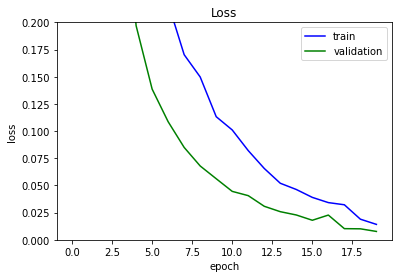

In [15]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [17]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [16]:
y_pred_ = model.predict([x[:3,0], x[:3,1]])

In [18]:
compute_accuracy(y[:3], y_pred_)

1.0

In [19]:
loss = model.evaluate(x=[x[:,0],x[:,1]], y=y)

y_pred_train = model.predict([x[:,0], x[:,1]])
train_accuracy = compute_accuracy(y, y_pred_train)

print("Loss = {}, Train Accuracy = {}".format(loss, train_accuracy))

8/8 [==============================] - 0s 35ms/step - loss: 0.0077
Loss = 0.0076861451379954815, Train Accuracy = 0.9915966386554622
